In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import numpy as np

In C:\Users\zorta\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\zorta\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\zorta\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\zorta\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\zorta\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/hurricane_images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/hurricane_images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


In [3]:
class_names = train_ds.class_names
print(class_names)

['damage', 'no_damage']


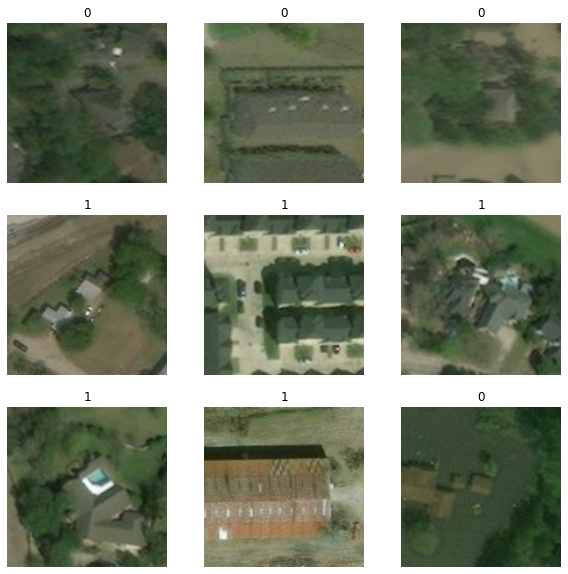

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
                                                                                                                        
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

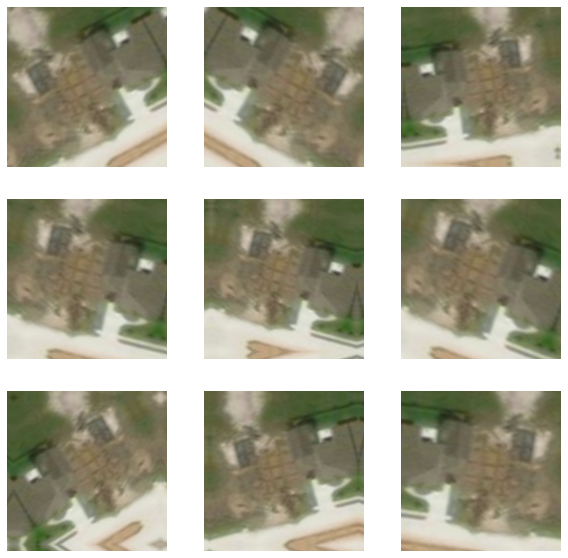

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
num_classes = 2
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation ='softmax')
])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)       

In [11]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
250/250 [==============================] - 117s 467ms/step - loss: 0.6717 - accuracy: 0.5514 - val_loss: 0.3567 - val_accuracy: 0.8555
Epoch 2/15
250/250 [==============================] - 117s 469ms/step - loss: 0.3096 - accuracy: 0.8683 - val_loss: 0.2261 - val_accuracy: 0.9090
Epoch 3/15
250/250 [==============================] - 114s 458ms/step - loss: 0.2154 - accuracy: 0.9109 - val_loss: 0.2495 - val_accuracy: 0.9020
Epoch 4/15
250/250 [==============================] - 115s 459ms/step - loss: 0.2075 - accuracy: 0.9160 - val_loss: 0.1766 - val_accuracy: 0.9260
Epoch 5/15
250/250 [==============================] - 118s 473ms/step - loss: 0.1765 - accuracy: 0.9283 - val_loss: 0.2238 - val_accuracy: 0.9165
Epoch 6/15
250/250 [==============================] - 123s 491ms/step - loss: 0.1560 - accuracy: 0.9370 - val_loss: 0.1604 - val_accuracy: 0.9350
Epoch 7/15
250/250 [==============================] - 120s 481ms/step - loss: 0.1601 - accuracy: 0.9363 - val_loss: 0.1986 -

In [12]:
model.save('../model/harvey_model1.h5')

In [13]:
new_model = keras.models.load_model('../model/harvey_model1.h5')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [24]:
prediction = new_model.predict(val_ds)
prediction[0]

array([9.9344300e-07, 9.9999905e-01], dtype=float32)

In [54]:
img = keras.preprocessing.image.load_img(
    "../data/test12.JPG", target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This area is {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This area is no_damage with a 73.11 percent confidence.


In [29]:
list(val_ds)[1]

(<tf.Tensor: shape=(32, 180, 180, 3), dtype=float32, numpy=
 array([[[[ 82.      , 103.      ,  64.      ],
          [ 82.566666, 103.566666,  64.566666],
          [ 83.      , 104.27778 ,  65.27778 ],
          ...,
          [ 81.      ,  95.      ,  60.      ],
          [ 80.566666,  94.566666,  59.566666],
          [ 80.      ,  94.      ,  59.      ]],
 
         [[ 83.13333 , 104.7     ,  65.7     ],
          [ 83.7     , 105.26666 ,  66.26666 ],
          [ 84.29074 , 105.977776,  66.977776],
          ...,
          [ 81.566666,  95.566666,  60.566666],
          [ 81.13333 ,  95.13333 ,  60.13333 ],
          [ 80.566666,  94.566666,  59.566666]],
 
         [[ 84.833336, 107.666664,  67.833336],
          [ 85.08518 , 108.23333 ,  68.24259 ],
          [ 85.47839 , 108.86729 ,  68.75617 ],
          ...,
          [ 83.18827 ,  97.18827 ,  62.18827 ],
          [ 82.5574  ,  96.5574  ,  61.557407],
          [ 81.833336,  95.833336,  60.833332]],
 
         ...,
 
      

In [32]:
ds = tf.data.Dataset.from_tensor_slices(list(val_ds.astype("float32")))

AttributeError: 'PrefetchDataset' object has no attribute 'astype'

In [33]:
model.evaluate(val_ds)

63/63 [==============================] - 12s 192ms/step - loss: 0.1024 - accuracy: 0.9655


[0.10242053866386414, 0.965499997138977]